In [1]:
import os
import numpy as np
import cv2
import transformations
import scipy.io as sio
import glob
from PIL import Image
from PIL import ImageDraw
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import copy
import tensorflow as tf
import sys
import data_generation
import networks
import param
import util
import truncated_vgg
from keras.backend.tensorflow_backend import set_session
from keras.optimizers import Adam
from keras.models import load_model

/software/Anaconda3-5.0.1-el7-x86_64/envs/DL_GPU/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/software/Anaconda3-5.0.1-el7-x86_64/envs/DL_GPU/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
vid_info_list = data_generation.make_vid_info_list('/home/jarvislam1999/posewarp-cvpr2018/data/test')

In [3]:
len(vid_info_list)

1

In [4]:
bbox=np.array(vid_info_list[0][1])

In [5]:
bbox[0]

array([687.64548803, 125.95119705, 205.08287293, 433.73848987])

In [6]:
pose=np.array(vid_info_list[0][2])

In [7]:
params = param.get_general_params()

In [8]:
params

{'IMG_HEIGHT': 256,
 'IMG_WIDTH': 256,
 'batch_size': 1,
 'data_dir': '/mnt/data/jarvislam1999/posewarp-cvpr2018/data',
 'limbs': [[0, 1],
  [2, 3],
  [3, 4],
  [5, 6],
  [6, 7],
  [8, 9],
  [9, 10],
  [11, 12],
  [12, 13],
  [2, 5, 8, 11]],
 'max_px_shift': 10,
 'max_rotate_degree': 5,
 'max_sat_factor': 0.05,
 'model_save_dir': '/mnt/data/jarvislam1999/posewarp-cvpr2018/models',
 'model_save_interval': 1000,
 'n_joints': 14,
 'n_limbs': 10,
 'n_training_iter': 200000,
 'obj_scale_factor': 1.14,
 'posemap_downsample': 2,
 'project_dir': '/mnt/data/jarvislam1999/posewarp-cvpr2018',
 'scale_max': 1.05,
 'scale_min': 0.9,
 'sigma_joint': 1.75,
 'test_interval': 500}

In [9]:
# warp generator
img_width = params['IMG_WIDTH']
img_height = params['IMG_HEIGHT']
pose_dn = params['posemap_downsample']
sigma_joint = params['sigma_joint']
n_joints = params['n_joints']
scale_factor = params['obj_scale_factor']
batch_size = params['batch_size']
limbs = params['limbs']
n_limbs = params['n_limbs']

output_generator_warp = []

In [10]:
x_src = np.zeros((batch_size, img_height, img_width, 3))
x_mask_src = np.zeros((batch_size, img_height, img_width, n_limbs + 1))
x_pose_src = np.zeros((batch_size, int(img_height / pose_dn), int(img_width / pose_dn), n_joints))
x_pose_tgt = np.zeros((batch_size, int(img_height / pose_dn), int(img_width / pose_dn), n_joints))
x_trans = np.zeros((batch_size, 2, 3, n_limbs + 1))
x_posevec_src = np.zeros((batch_size, n_joints * 2))
x_posevec_tgt = np.zeros((batch_size, n_joints * 2))
y = np.zeros((batch_size, img_height, img_width, 3))

In [11]:
# 1. choose random video.
vid = np.random.choice(len(vid_info_list), 1)[0]

vid_bbox = vid_info_list[vid][1]
vid_x = vid_info_list[vid][2]
vid_path = vid_info_list[vid][3]

In [12]:
# 2. choose pair of frames
n_frames = vid_x.shape[2]
frames = np.array([0,4])
while abs(frames[0] - frames[1]) / (n_frames * 1.0) <= 0.02:
    frames = np.random.choice(n_frames, 2, replace=False)

In [13]:
frames

array([0, 4])

In [14]:
os.path.join(vid_path, str(frames[0] + 1) + '.jpg') == '/mnt/data/jarvislam1999/posewarp-cvpr2018/data/train/frames/Flavia Pennetta in 4k/1.jpg'

False

In [15]:
vid_path

'/home/jarvislam1999/posewarp-cvpr2018/data/test/frames/Golf Lessons - Stop Topping Fairway Woods'

In [16]:
vid_x[:,:,0]

array([[751.29189687, 125.95119705],
       [756.00644567, 203.7412523 ],
       [706.50368324, 239.10036832],
       [687.64548803, 290.96040516],
       [725.36187845, 302.74677716],
       [807.8664825 , 210.81307551],
       [857.36924494, 253.24401473],
       [892.72836096, 298.03222836],
       [723.00460405, 349.89226519],
       [732.43370166, 465.39871087],
       [748.93462247, 559.68968692],
       [786.65101289, 361.6786372 ],
       [786.65101289, 474.82780847],
       [720.64732965, 547.90331492]])

In [17]:
vid_info_list[0][1]

array([[687.64548803, 125.95119705, 205.08287293, 433.73848987],
       [652.28637201, 118.87937385, 169.72375691, 497.38489871],
       [635.7854512 , 130.66574586, 169.72375691, 469.09760589],
       [621.64180479, 140.09484346, 150.86556169, 438.45303867],
       [673.50184162, 142.45211786, 106.07734807, 424.30939227],
       [623.99907919, 128.30847145, 124.93554328, 445.52486188],
       [697.07458564, 125.95119705, 157.9373849 , 464.38305709],
       [657.00092081, 137.73756906, 132.00736648, 447.88213628]])

In [18]:
vid_info_list[0][1] = [[120,230,250,370], \
                       [185,230,290,370], \
                       [380,230,290,370], \
                       [635,230,220,370], \
                       [795,95,245,345], \
                       [990,170,210,340], \
                       [1130,270,160,340],\
                       [1200,220,120,370]]
vid_info_list[0][1] = np.array(vid_info_list[0][1])

vid_x[:,:,0] = [[ 260,  260],\
                [ 247,  305],\
                [ 245,  300],\
                [ 310,  320],\
                [ 350,  300],\
                [ 240,  310],\
                [ 250,  370],\
                [ 300,  400],\
                [ 220,  425],\
                [ 220,  425],\
                [ 200,  490],\
                [ 220,  500 ],\
                [ 140,  550],\
                [ 190,  570]]
vid_x[:,:,0] = np.array(vid_x[:,:,0])


vid_x[:,:,4] = [[ 890,  100],\
                [ 900,  135 ],\
                [ 885,  160],\
                [ 860,  105],\
                [ 820,  140],\
                [ 940,  140],\
                [ 990,  190],\
                [ 1020,  170],\
                [ 910,  260],\
                [ 880,  340],\
                [ 800,  390],\
                [ 940,  275 ],\
                [ 930,  340],\
                [ 917,  420]]
vid_x[:,:,4] = np.array(vid_x[:,:,4])

vid_bbox = vid_info_list[vid][1]
vid_x = vid_info_list[vid][2]
vid_path = '/home/jarvislam1999/posewarp-cvpr2018/data/test001/'


In [19]:
I0, joints0, scale0, pos0 = data_generation.read_frame(vid_path, frames[0], vid_bbox, vid_x)
I1, joints1, scale1, pos1 = data_generation.read_frame(vid_path, frames[1], vid_bbox, vid_x)

/home/jarvislam1999/posewarp-cvpr2018/data/test001/1.jpg
/home/jarvislam1999/posewarp-cvpr2018/data/test001/5.jpg


In [20]:
np.array(vid_x[:,:,0])

array([[260., 260.],
       [247., 305.],
       [245., 300.],
       [310., 320.],
       [350., 300.],
       [240., 310.],
       [250., 370.],
       [300., 400.],
       [220., 425.],
       [220., 425.],
       [200., 490.],
       [220., 500.],
       [140., 550.],
       [190., 570.]])

In [21]:
print(pos0)

[245. 415.]


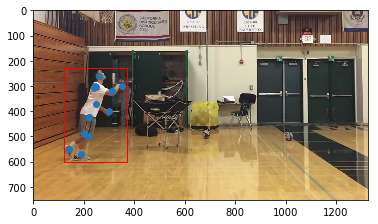

In [22]:
img_01 = Image.open(vid_path + '/1.jpg')
#img_01 = Image.open(vid_path + '/1.jpg')

img_01 = np.array(img_01, dtype=np.uint8)

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(img_01)

# Create a Rectangle patch
rect = patches.Rectangle((vid_info_list[0][1][0][0],\
                          vid_info_list[0][1][0][1]),\
                         vid_info_list[0][1][0][2],\
                         vid_info_list[0][1][0][3],linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)
plt.scatter(vid_x[:,0,0], vid_x[:,1,0])


#plt.imshow(cv2.cvtColor(I0, cv2.COLOR_BGR2RGB))
plt.show()

In [23]:
vid_info_list[0][1][0]

array([120, 230, 250, 370])

In [24]:
vid_x[:,:,0]

array([[260., 260.],
       [247., 305.],
       [245., 300.],
       [310., 320.],
       [350., 300.],
       [240., 310.],
       [250., 370.],
       [300., 400.],
       [220., 425.],
       [220., 425.],
       [200., 490.],
       [220., 500.],
       [140., 550.],
       [190., 570.]])

In [25]:
do_augment = False
if scale0 > scale1:
    scale = scale_factor / scale0
else:
    scale = scale_factor / scale1

pos = (pos0 + pos1) / 2.0
print(I0)
I0 = np.array(I0, dtype=np.uint8)
#print(I0)
I0, joints0 = data_generation.center_and_scale_image(I0, img_width, img_height, pos0, scale, joints0)
I1, joints1 = data_generation.center_and_scale_image(I1, img_width, img_height, pos1, scale, joints1)
print(I0)

[[[192 204 216]
  [193 205 217]
  [193 205 217]
  ...
  [138 153 169]
  [147 162 178]
  [152 167 183]]

 [[193 205 217]
  [193 205 217]
  [193 205 217]
  ...
  [137 152 168]
  [145 160 176]
  [153 168 184]]

 [[193 205 217]
  [193 205 217]
  [193 205 217]
  ...
  [136 151 167]
  [141 156 172]
  [153 168 184]]

 ...

 [[ 82 156 212]
  [ 82 156 212]
  [ 81 155 211]
  ...
  [134 199 238]
  [133 198 237]
  [135 197 237]]

 [[ 81 156 212]
  [ 81 156 212]
  [ 81 155 211]
  ...
  [134 199 238]
  [134 199 238]
  [136 198 238]]

 [[ 81 156 212]
  [ 81 156 212]
  [ 80 155 211]
  ...
  [134 199 238]
  [134 199 238]
  [137 199 239]]]
[[[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [ 70  81 109]
  [ 71  82 110]
  [ 68  81 110]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [ 71  83 108]
  [ 71  83 110]
  [ 68  82 109]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [ 68  81 104]
  [ 69  81 105]
  [ 64  80 104]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

In [26]:
print(I0[0,0,:])

[0 0 0]


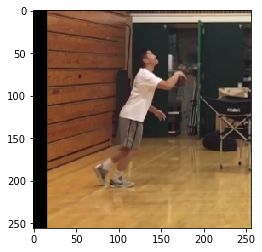

In [27]:
plt.imshow(cv2.cvtColor(I0, cv2.COLOR_BGR2RGB))
plt.show()

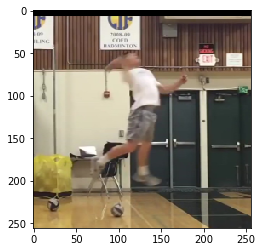

In [28]:
plt.imshow(cv2.cvtColor(I1, cv2.COLOR_BGR2RGB))
plt.show()

In [29]:
I2 = copy.deepcopy(I1)

In [30]:
I0 = (I0 / 255.0 - 0.5) * 2.0
I1 = (I1 / 255.0 - 0.5) * 2.0
print(I0.shape)

(256, 256, 3)


In [31]:
do_augment = False

#print(I0)
print(I0.shape)
if do_augment:
    rflip, rscale, rshift, rdegree, rsat = data_generation.rand_augmentations(params)
    print(rscale)
    I0, joints0 = data_generation.augment(I0, joints0, rflip, rscale, rshift, rdegree, rsat, img_height, img_width)
    I1, joints1 = data_generation.augment(I1, joints1, rflip, rscale, rshift, rdegree, rsat, img_height, img_width)
    # begin augment transformation
    rflip, rscale, rshift, rdegree, rsat = data_generation.rand_augmentations(params)
    print(rflip)
    print(rscale)
    print(rshift)
    print(rdegree)
    print(rsat)
    #print(I0.shape)
    #I0, joints0 = data_generation.aug_flip(I0, rflip, joints0)
    #I0, joints0 = data_generation.aug_scale(I0, rscale, joints0)
    #I0, joints0 = data_generation.aug_shift(I0, img_width, img_height, rshift, joints0)
    #I0, joints0 = data_generation.aug_rotate(I0, img_width, img_height, rdegree, joints0)
    #I0 = data_generation.aug_saturation(I0, rsat)

    print(I0)

    #I1, joints1 = data_generation.aug_flip(I1, rflip, joints1)
    #I1, joints1 = data_generation.aug_scale(I1, rscale, joints1)
    #I1, joints1 = data_generation.aug_shift(I1, img_width, img_height, rshift, joints1)
    #I1, joints1 = data_generation.aug_rotate(I1, img_width, img_height, rdegree, joints1)
    #I1 = data_generation.aug_saturation(I1, rsat)

posemap0 = data_generation.make_joint_heatmaps(img_height, img_width, joints0, sigma_joint, pose_dn)
posemap1 = data_generation.make_joint_heatmaps(img_height, img_width, joints1, sigma_joint, pose_dn)

src_limb_masks = data_generation.make_limb_masks(limbs, joints0, img_width, img_height)
src_bg_mask = np.expand_dims(1.0 - np.amax(src_limb_masks, axis=2), 2)
src_masks = np.log(np.concatenate((src_bg_mask, src_limb_masks), axis=2) + 1e-10)
#print(I1)
#print(src_bg_mask)

(256, 256, 3)


In [32]:
pose_map = np.sum(posemap0, axis = 2)

In [33]:
pose_map.shape

(128, 128)

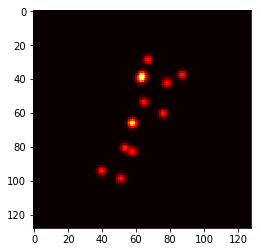

In [34]:
plt.imshow(pose_map, cmap='hot', interpolation='nearest')
plt.show()

In [35]:
x_src[0, :, :, :] = I0
x_pose_src[0, :, :, :] = posemap0
x_pose_tgt[0, :, :, :] = posemap1
x_mask_src[0, :, :, :] = src_masks
x_trans[0, :, :, 0] = np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0]])
x_trans[0, :, :, 1:] = data_generation.get_limb_transforms(limbs, joints0, joints1)

x_posevec_src[0, :] = joints0.flatten()
x_posevec_tgt[0, :] = joints1.flatten()

print(I1.shape)
y[0, :, :, :] = I1
#print(x_src)

/home/jarvislam1999/posewarp-cvpr2018/code/transformations.py:124: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  params = np.linalg.lstsq(A, b)[0]


(256, 256, 3)


In [36]:
out = [x_src, x_pose_src, x_pose_tgt, x_mask_src, x_trans]

In [37]:
output_generator_warp.append((out,y))

In [38]:
x_in, y_in = output_generator_warp[0]

In [42]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

In [43]:
vgg_model = truncated_vgg.vgg_norm()
networks.make_trainable(vgg_model, False)
response_weights = sio.loadmat('../data/vgg_activation_distribution_train.mat')
model = networks.network_posewarp(params)
model.compile(optimizer=Adam(lr=1e-4), loss=[networks.vgg_loss(vgg_model, response_weights, 12)])

In [44]:
#from keras.models import load_weights
model.load_weights('/home/jarvislam1999/posewarp-cvpr2018/models/vgg_100000.h5')

In [45]:
#train_loss = model.train_on_batch(x_in, y_in)

In [46]:
#train_loss

In [47]:
print(y[0].shape)

(256, 256, 3)


In [48]:
y_out = model.predict(x_in, 1)

In [49]:
y_out.shape

(1, 256, 256, 3)

In [50]:
y_out[0].shape

(256, 256, 3)

In [51]:
y_final = copy.deepcopy(y_out[0])

In [52]:
y_final = (y_final/2.0 + 0.5)*255.0
#y_final = (y_final / 255.0 - 0.5) * 2.0

In [53]:
y_final = y_final.astype(np.uint8)

In [54]:
y_final_b = copy.deepcopy(y_final[:,:,0])
y_final[:,:,0] = y_final[:,:,2]
y_final[:,:,2] = y_final_b

In [55]:
y_final

array([[[ 31,  47,  37],
        [ 17,  16,  17],
        [ 11,  12,  12],
        ...,
        [ 97,  87,  78],
        [ 98,  90,  83],
        [109, 100,  93]],

       [[ 15,  17,  14],
        [  7,   4,   3],
        [  5,   4,   3],
        ...,
        [111,  83,  69],
        [115,  87,  69],
        [101,  86,  73]],

       [[ 11,  10,  11],
        [  6,   4,   5],
        [  5,   5,   5],
        ...,
        [105,  80,  69],
        [107,  79,  67],
        [ 98,  90,  79]],

       ...,

       [[ 13,  12,  11],
        [  6,   5,   4],
        [  5,   5,   5],
        ...,
        [199, 160,  81],
        [204, 163,  75],
        [183, 151, 105]],

       [[ 11,  12,  13],
        [  4,   4,   3],
        [  4,   4,   4],
        ...,
        [204, 160,  69],
        [206, 170,  64],
        [186, 152, 100]],

       [[ 30,  24,  36],
        [  8,   8,   9],
        [  7,   7,   8],
        ...,
        [180, 156,  96],
        [178, 159,  95],
        [165, 152, 114]]

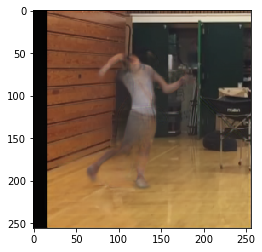

In [56]:
#plt.imshow(cv2.cvtColor(y_final, cv2.COLOR_BGR2RGB))
plt.imshow(y_final)
plt.show()

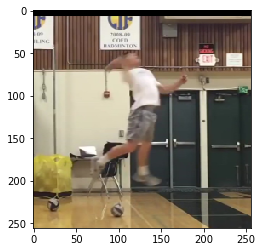

In [57]:
plt.imshow(cv2.cvtColor(I2, cv2.COLOR_BGR2RGB))
plt.show()